In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import sys

In [2]:
df = pd.read_csv('un.csv.1')

In [3]:
df.shape

(207, 14)

In [4]:
df.head()

,country,region,tfr,contraception,educationMale,educationFemale,lifeMale,lifeFemale,infantMortality,GDPperCapita,economicActivityMale,economicActivityFemale,illiteracyMale,illiteracyFemale
0,Afghanistan,Asia,6.90,NaN,NaN,NaN,45.0,46.0,154,2848,87.5,7.2,52.800,85.00
1,Albania,Europe,2.60,NaN,NaN,NaN,68.0,74.0,32,863,NaN,NaN,NaN,NaN
2,Algeria,Africa,3.81,52,11.1,9.9,67.5,70.3,44,1531,76.4,7.8,26.100,51.00
3,American.Samoa,Asia,NaN,NaN,NaN,NaN,68.0,73.0,11,NaN,58.8,42.4,0.264,0.36
4,Andorra,Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.count()

country                   207
region                    207
tfr                       197
contraception             144
educationMale              76
educationFemale            76
lifeMale                  196
lifeFemale                196
infantMortality           201
GDPperCapita              197
economicActivityMale      165
economicActivityFemale    165
illiteracyMale            160
illiteracyFemale          160
dtype: int64

In [6]:
# Suggestion from Daniel, shows how many are null in each column.
df.isnull().sum()

country                     0
region                      0
tfr                        10
contraception              63
educationMale             131
educationFemale           131
lifeMale                   11
lifeFemale                 11
infantMortality             6
GDPperCapita               10
economicActivityMale       42
economicActivityFemale     42
illiteracyMale             47
illiteracyFemale           47
dtype: int64

In [7]:
df.count().sort_values(ascending=False)

region                    207
country                   207
infantMortality           201
GDPperCapita              197
tfr                       197
lifeFemale                196
lifeMale                  196
economicActivityFemale    165
economicActivityMale      165
illiteracyFemale          160
illiteracyMale            160
contraception             144
educationFemale            76
educationMale              76
dtype: int64

In [8]:
df.dtypes

country                    object
region                     object
tfr                       float64
contraception             float64
educationMale             float64
educationFemale           float64
lifeMale                  float64
lifeFemale                float64
infantMortality           float64
GDPperCapita              float64
economicActivityMale      float64
economicActivityFemale    float64
illiteracyMale            float64
illiteracyFemale          float64
dtype: object

In [9]:
from scipy.cluster.vq import vq, kmeans, whiten

clusters = []
k_range  = 10
whitened = whiten(df[['lifeMale', 'lifeFemale', 'infantMortality', 'GDPperCapita']].dropna())

for i in range(k_range):
    codebook, distortion = kmeans(whitened, i+1)
    clusters.append({ 'size': i+1, 'codebook': codebook, 'distortion': distortion })

In [10]:
clusters[2]

{'codebook': array([[ 5.12164539,  4.78508111,  2.47324317,  0.09593905],
        [ 7.55365089,  7.21563377,  0.19925385,  2.43214287],
        [ 6.85649973,  6.57747019,  0.7429855 ,  0.30474183]]),
 'distortion': 0.74566783727885033,
 'size': 3}

In [11]:
# Calculate the distance between each point and the centroids of each cluster.
features = df[['lifeMale', 'lifeFemale', 'infantMortality', 'GDPperCapita']].dropna()
features.shape

(188, 4)

In [12]:
import math

def distance_from_centroid(centroid):
    return lambda pt: math.sqrt(math.pow(centroid[0] - pt[0], 2) +
                                math.pow(centroid[1] - pt[1], 2) +
                                math.pow(centroid[2] - pt[2], 2) +
                                math.pow(centroid[3] - pt[3], 2))

# Probably want to use the whitened data to get meaningful results.
# Distances will be a M by k data frame.
for i in range(k_range):
    clusters[i]['distances'] = pd.DataFrame(index=features.index)
    for j in range(clusters[i]['size']):
        f = distance_from_centroid(clusters[i]['codebook'][j])
        # If I use features here instead of whitened,
        # they all cluster around the first centroid (for cluster 3)
        clusters[i]['distances']['d{}'.format(j+1)] = map(f, whitened)

In [13]:
clusters[2]['distances'].head()

,d1,d2,d3
0,1.719691,6.063394,4.622629
1,3.110660,2.547496,0.266041
2,2.721985,2.674661,0.468742
5,1.001701,5.632920,4.026191
7,3.591763,1.654601,0.768677


In [14]:
def get_closest(distances):
    return distances.idxmin()

def d_squared(distances):
    return math.pow(distances.min(), 2)
    
for i in range(k_range):
    try:
        clusters[i]['distances'].drop(labels=['closest'], inplace=True, axis=1)
    except ValueError:
        pass
    clusters[i]['distances']['closest'] = clusters[i]['distances'].apply(func=get_closest, axis=1)
    clusters[i]['distances']['d_squared'] = clusters[i]['distances'].apply(func=d_squared, axis=1)

In [15]:
clusters[2]['distances'].head()

,d1,d2,d3,closest,d_squared
0,1.719691,6.063394,4.622629,d1,2.957336
1,3.110660,2.547496,0.266041,d3,0.070778
2,2.721985,2.674661,0.468742,d3,0.219719
5,1.001701,5.632920,4.026191,d1,1.003404
7,3.591763,1.654601,0.768677,d3,0.590865


In [16]:
clusters[2]['distances'].pivot(columns='closest', values='d_squared').head()

closest,d1,d2,d3
0,2.957336,NaN,NaN
1,NaN,NaN,0.070778
2,NaN,NaN,0.219719
5,1.003404,NaN,NaN
7,NaN,NaN,0.590865


In [17]:
# Average within-cluster sum of squares (for cluster 3).
clusters[2]['distances'].pivot(columns='closest', values='d_squared').sum().mean()

46.902140289325537

In [18]:
# Calculate average within-cluster sum of squares for each centroid.
wcss_averages = []
for i in range(k_range):
    wcss_averages.append(clusters[i]['distances'].pivot(columns='closest', values='d_squared').sum().mean())

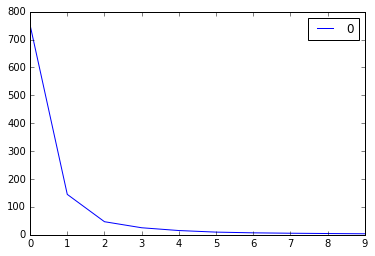

In [19]:
%matplotlib inline

pd.DataFrame(wcss_averages).plot()

In [20]:
# We see the biggest drops in average wcss between 1 and 2, and 2 and 3.
# Now we use kmeans with a cluster size of 3.
cluster_size         = 3
distances            = pd.DataFrame(index=features.index)
codebook, distortion = kmeans(whitened, cluster_size)

for i in range(cluster_size):
    f = distance_from_centroid(codebook[i])
    distances['d{}'.format(i+1)] = map(f, whitened)

features['closest'] = distances.idxmin(axis=1)

colors = { 'd1': 0, 'd2': 1, 'd3': 2 }
features['color'] = map(lambda c: colors[c], features['closest'])

In [21]:
features.head()

,lifeMale,lifeFemale,infantMortality,GDPperCapita,closest,color
0,45.0,46.0,154,2848,d3,2
1,68.0,74.0,32,863,d2,1
2,67.5,70.3,44,1531,d2,1
5,44.9,48.1,124,355,d3,2
7,69.6,76.8,22,8055,d2,1


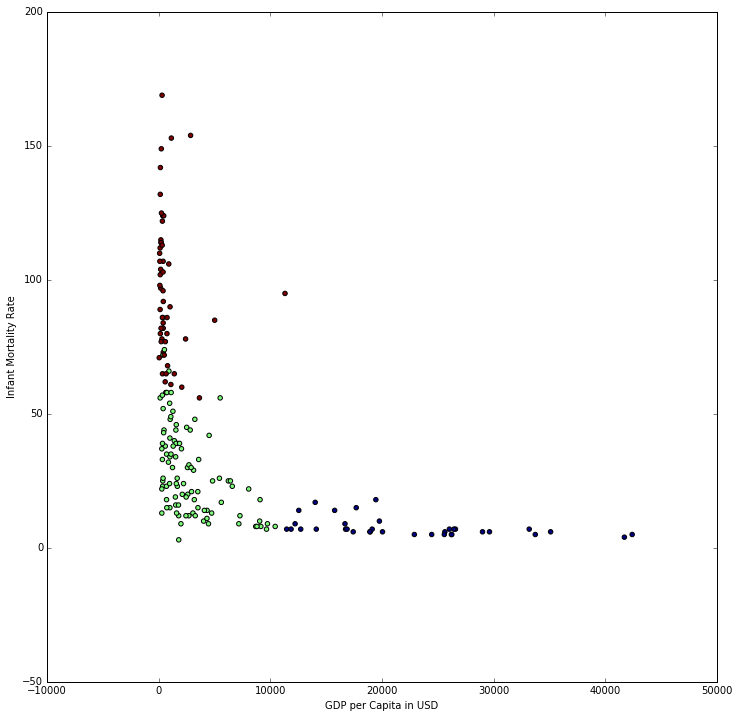

In [22]:
plt.figure(figsize=(12,12))
plt.scatter(features['GDPperCapita'], features['infantMortality'], c=features['color'])
plt.xlabel('GDP per Capita in USD')
plt.ylabel('Infant Mortality Rate')

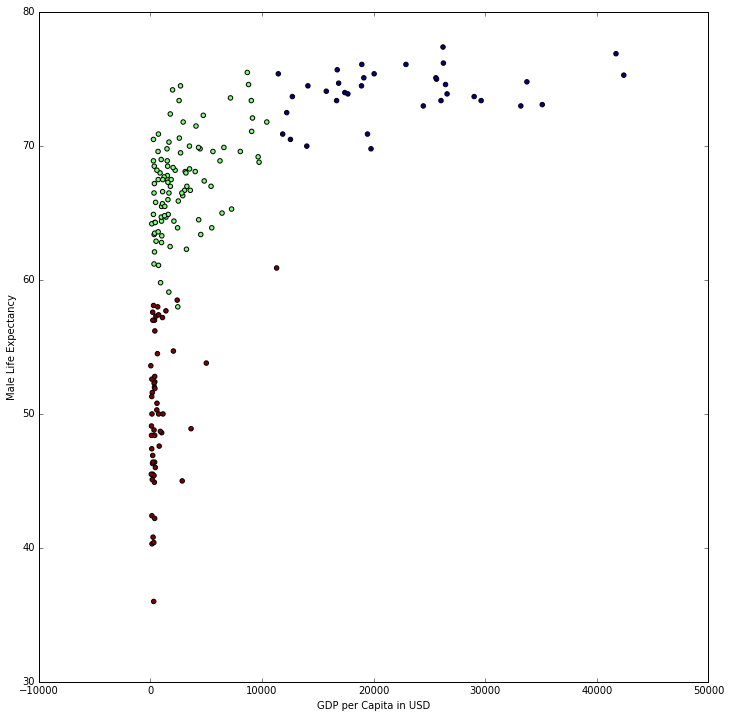

In [23]:
plt.figure(figsize=(12,12))
plt.scatter(features['GDPperCapita'], features['lifeMale'], c=features['color'])
plt.xlabel('GDP per Capita in USD')
plt.ylabel('Male Life Expectancy')

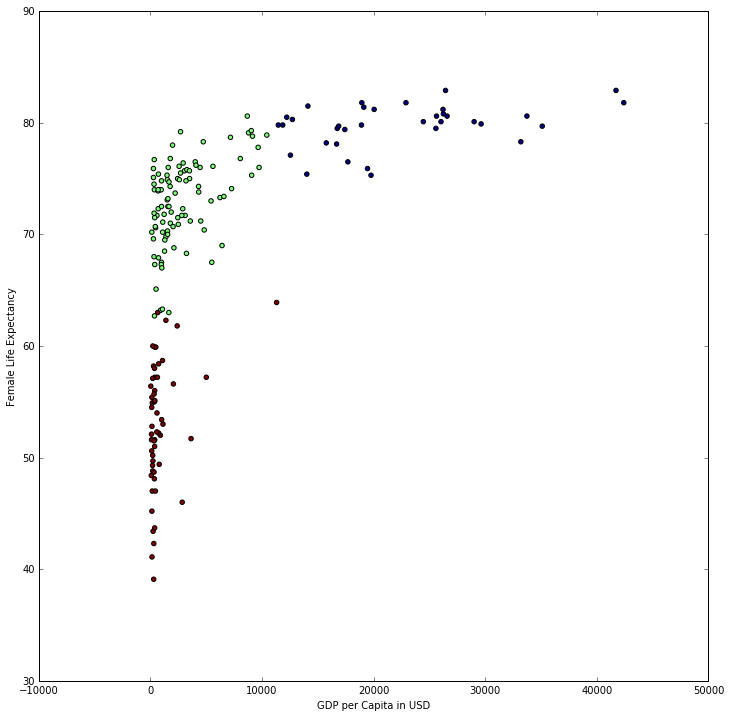

In [24]:
plt.figure(figsize=(12,12))
plt.scatter(features['GDPperCapita'], features['lifeFemale'], c=features['color'])
plt.xlabel('GDP per Capita in USD')
plt.ylabel('Female Life Expectancy')